In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [158]:
train=pd.read_csv("data/소득예측경진대회/train.csv")
test=pd.read_csv("data/소득예측경진대회/test.csv")
sample_submission = pd.read_csv("data/소득예측경진대회/sample_submission.csv")

In [93]:
train.head()

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target
0,32,Private,309513,12,1,Craft-repair,Husband,White,Male,0,0,40,United-States,0
1,33,Private,205469,10,1,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
2,46,Private,149949,10,1,Craft-repair,Husband,White,Male,0,0,40,United-States,0
3,23,Private,193090,13,0,Adm-clerical,Own,White,Female,0,0,30,United-States,0
4,55,Private,60193,9,0,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0


In [38]:
train.shape, test.shape

((17480, 16), (15081, 15))

In [159]:
train.drop(['id','education'],axis=1, inplace=True)
test.drop(['id','education'],axis=1, inplace=True)

다중공선성과 education을 라벨링한 것이니 드랍하겠습니다.

In [40]:
train.shape, test.shape

((17480, 14), (15081, 13))

In [5]:
train.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,target
count,17480.000000,1.748000e+04,17480.000000,17480.000000,17480.00000,17480.000000,17480.000000
mean,38.720995,1.897610e+05,10.036556,1076.644508,83.87460,40.002460,0.234897
std,14.079617,1.049929e+05,2.604415,7439.498620,396.03288,12.671265,0.423947
min,17.000000,1.228500e+04,1.000000,0.000000,0.00000,1.000000,0.000000
25%,27.000000,1.181558e+05,9.000000,0.000000,0.00000,38.000000,0.000000
50%,37.000000,1.781340e+05,10.000000,0.000000,0.00000,40.000000,0.000000
75%,48.000000,2.373180e+05,12.000000,0.000000,0.00000,45.000000,0.000000
max,90.000000,1.455435e+06,16.000000,99999.000000,4356.00000,99.000000,1.000000


**Observation**

* age에 90세인 분이 계십니다.
* capital_gain max를 보니 99999가 존재하고, 사분위수 데이터가 독특합니다.
* capital_loss의 사분위수도 이상합니다.
* hours.per.week에서 주 1시간 근무하는 분이 계시고, 주에 99시간 근무를 하시는 분도 계십니다.

In [156]:
train.isnull().sum()

id                   0
age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
target               0
dtype: int64

In [157]:
test.isnull().sum()

id                0
age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
dtype: int64

* 일의 유형과 직업, 본 국적등의 정보에 Null값이 있네요. 예민한 질문이어서 그런 것 같습니다.

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17480 entries, 0 to 17479
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             17480 non-null  int64 
 1   workclass       15644 non-null  object
 2   fnlwgt          17480 non-null  int64 
 3   education.num   17480 non-null  int64 
 4   marital.status  17480 non-null  object
 5   occupation      15637 non-null  object
 6   relationship    17480 non-null  object
 7   race            17480 non-null  object
 8   sex             17480 non-null  object
 9   capital.gain    17480 non-null  int64 
 10  capital.loss    17480 non-null  int64 
 11  hours.per.week  17480 non-null  int64 
 12  native.country  16897 non-null  object
 13  target          17480 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 1.9+ MB


<AxesSubplot:>

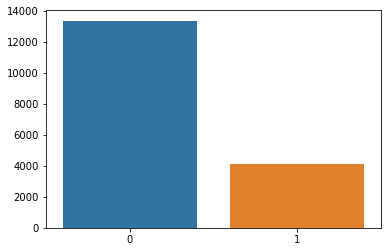

In [9]:
targets = train['target'].value_counts()
sns.barplot(x=targets.index, y= targets.values)

균형을 맞춰줄 필요가 있어보입니다.

In [160]:
num_cols = train.select_dtypes(include='int64').columns.tolist()
cat_cols = train.select_dtypes(exclude='int64').columns.tolist()
num_cols.remove('target')

<Figure size 864x360 with 0 Axes>

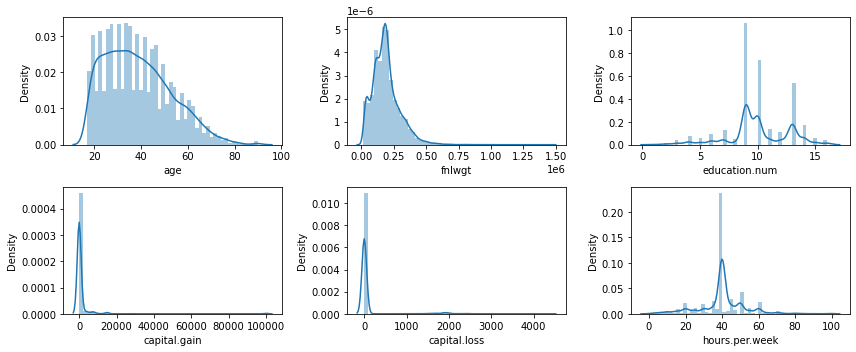

In [7]:
def show_dist_plot(df, columns):
    i = 0
    plt.figure(figsize=(12,5))
    plt.subplots(2,3,figsize=(12,5))
    for column in columns:
        i+=1
        plt.subplot(2,3,i)
        sns.distplot(df[column])
    plt.tight_layout()
    
show_dist_plot(train,num_cols)

**Obseravtion**

* 정규화 작업이 필요합니다.
* 표준화 작업이 필요합니다.
* 이상치가 존재합니다.

<Figure size 1728x720 with 0 Axes>

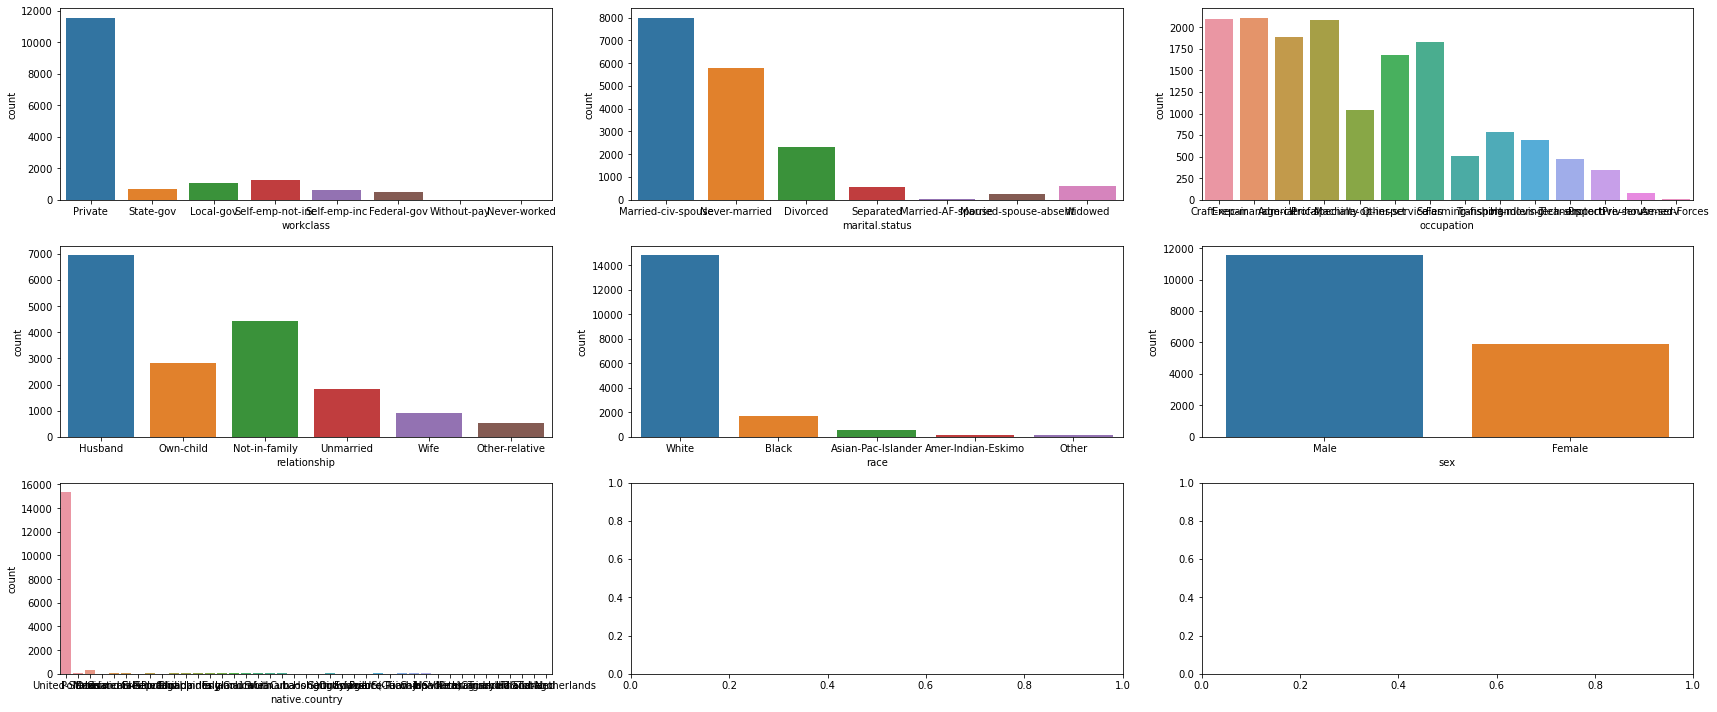

In [14]:
def show_cat_plot(df, columns):
    i = 0
    plt.figure(figsize=(24,10))
    plt.subplots(3,3,figsize=(24,10))
    for column in columns:
        i+=1
        plt.subplot(3,3,i)
        sns.countplot(df[column])
    plt.tight_layout()
    
show_cat_plot(train,cat_cols)

# Feature Engineering

In [288]:
train.head()

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target,total_capital
0,32,Private,309513,12,not alone,Craft-repair,Husband,White,Male,0,0,40,United-States,0,0
1,33,Private,205469,10,not alone,Exec-managerial,Husband,White,Male,0,0,40,United-States,1,0
2,46,Private,149949,10,not alone,Craft-repair,Husband,White,Male,0,0,40,United-States,0,0
3,23,Private,193090,13,alone,Adm-clerical,Own-child,White,Female,0,0,30,United-States,0,0
4,55,Private,60193,9,alone,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0,0


In [161]:
train['relationship'] = train['relationship'].replace(['Own-child','Unmarried'],'Own')
test['relationship'] = test['relationship'].replace(['Own-child','Unmarried'],'Own')

train['marital.status'] = train['marital.status'].replace(['Never-married','Divorced','Widowed','Separated'], 'alone')
test['marital.status'] = test['marital.status'].replace(['Never-married','Divorced','Widowed','Separated'], 'alone')

train['marital.status'] = train['marital.status'].replace(['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse'], 'not alone')
test['marital.status'] = test['marital.status'].replace(['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse'], 'not alone')

train['marital.status']=train['marital.status'].map({'not alone':1,'alone':0})
test['marital.status']=test['marital.status'].map({'not alone':1,'alone':0})

<AxesSubplot:title={'center':'Not Alone or Alone?'}, xlabel='Not Alone <-> Alone'>

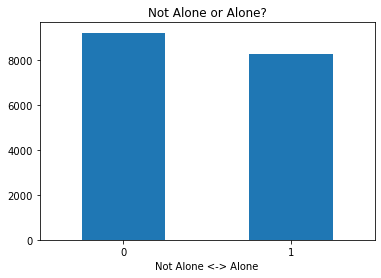

In [6]:
train['marital.status'].value_counts().plot.bar(title="Not Alone or Alone?",xlabel='Not Alone <-> Alone',rot=0)

<AxesSubplot:>

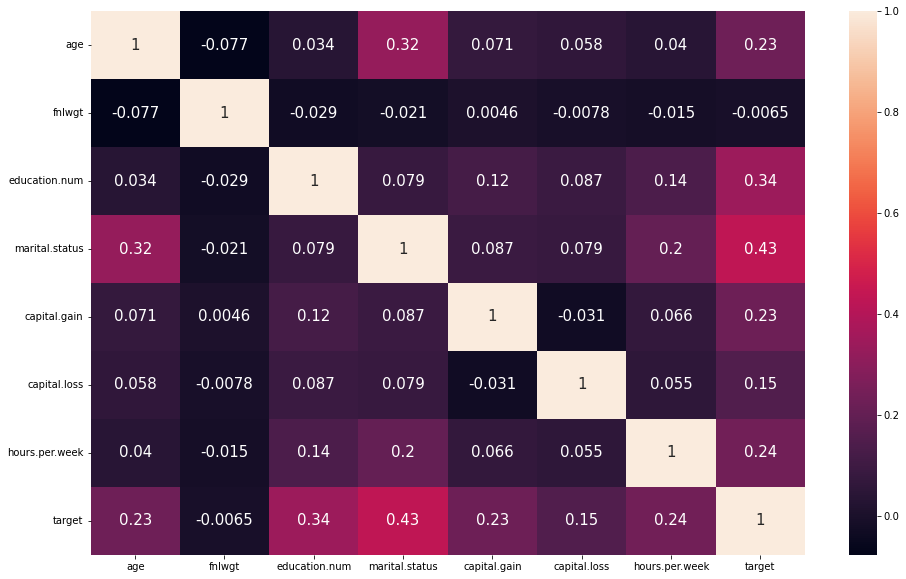

In [7]:
plt.figure(figsize=(16,10))
sns.heatmap(train.corr(), annot=True,annot_kws={'size':15})

In [162]:
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from sklearn.metrics import classification_report,accuracy_score

from feature_engine.imputation import AddMissingIndicator,RandomSampleImputer
from feature_engine.encoding import OneHotEncoder
from feature_engine.transformation.yeojohnson import YeoJohnsonTransformer
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

In [163]:
X = train.drop(['target'],axis=1)
y = train.target

X_train , X_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state=42)
#nan
ran = RandomSampleImputer(variables=['workclass',
 'occupation',
 'native.country'])

ran.fit(X_train,y_train)
X_train=ran.transform(X_train)
X_test = ran.transform(X_test)

#one-hot
enc = OneHotEncoder(variables=['workclass',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country'])

X_train=enc.fit_transform(X_train)
X_test =enc.transform(X_test)

#imbalance
sm = SMOTE(random_state=42)
X_train,y_train=sm.fit_resample(X_train,y_train)

#fromer
former= YeoJohnsonTransformer(variables=['capital.gain'])
X_train = former.fit_transform(X_train,y_train)
X_test = former.transform(X_test)

In [166]:
test =enc.transform(test)
test =former.transform(test)

Correlations between features and target:

age:  0.2865
fnlwgt: -0.0181
education.num:  0.3813
marital.status:  0.4292
capital.gain:  0.2586
capital.loss:  0.1318
hours.per.week:  0.2928
workclass_Private: -0.2893
workclass_Self-emp-not-inc: -0.0901
workclass_Local-gov: -0.0816
workclass_Self-emp-inc:  0.0116
workclass_Federal-gov: -0.0336
workclass_State-gov: -0.0688
workclass_Without-pay: -0.0193
workclass_Never-worked: -0.0193
occupation_Machine-op-inspct: -0.1546
occupation_Other-service: -0.2510
occupation_Prof-specialty:  0.0229
occupation_Protective-serv: -0.0453
occupation_Exec-managerial:  0.0411
occupation_Adm-clerical: -0.2018
occupation_Craft-repair: -0.1557
occupation_Transport-moving: -0.1121
occupation_Tech-support: -0.0634
occupation_Sales: -0.1207
occupation_Farming-fishing: -0.1104
occupation_Handlers-cleaners: -0.1515
occupation_Priv-house-serv: -0.0571
occupation_Armed-Forces: -0.0103
relationship_Husband:  0.3304
relationship_Other-relative: -0.1293
relationship_Ow

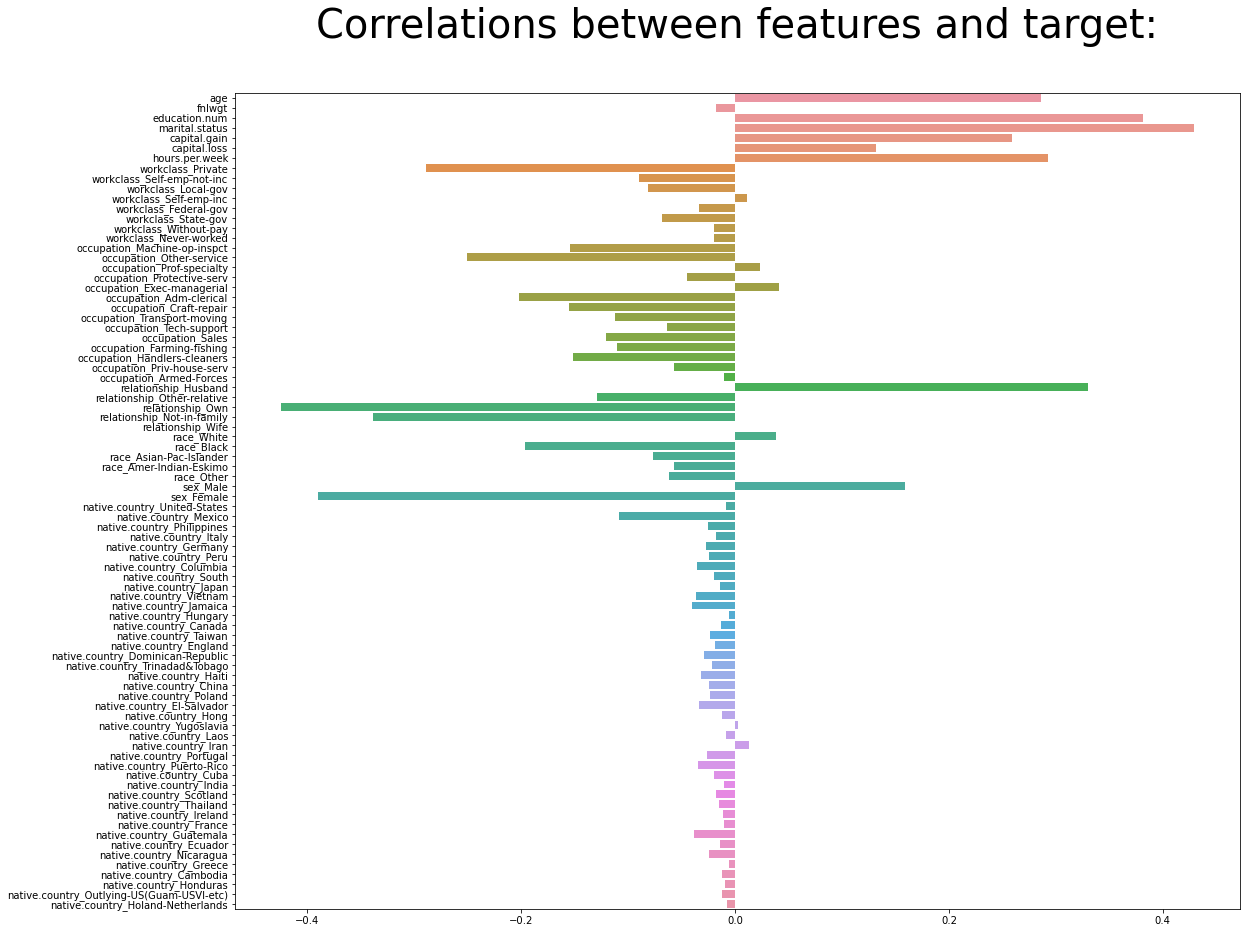

In [97]:
from scipy.stats import pearsonr

print("Correlations between features and target:\n")
correlations = {}
for col in X_train.columns:
    corr, _ = pearsonr(X_train[col], y_train)
    correlations[col] = corr
    print(f"{col}: {corr: .4f}")
plt.figure(figsize=(18,15))
sns.barplot(y=list(correlations.keys()), x=list(correlations.values()))
plt.title("Correlations between features and target:\n", fontsize=40)
plt.show()


In [101]:
def Model(model):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    print(accuracy_score(y_test, pred))
    print(classification_report(y_test,pred))
    
Model(LGBMClassifier())

0.8693745232646835
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      4003
           1       0.76      0.66      0.71      1241

    accuracy                           0.87      5244
   macro avg       0.83      0.80      0.81      5244
weighted avg       0.87      0.87      0.87      5244



In [175]:
from optuna.samplers import TPESampler
import optuna

In [168]:
pred=model.predict(test)

In [169]:
sample_submission['target'] = pred
sample_submission.to_csv("data/소득예측경진대회/submission.csv",index=False)

Correlations between features and target:

age:  0.2865
fnlwgt: -0.0181
education.num:  0.3813
marital.status:  0.4292
capital.gain:  0.2586
capital.loss:  0.1318
hours.per.week:  0.2928
workclass_Private: -0.2893
workclass_Self-emp-not-inc: -0.0901
workclass_Local-gov: -0.0816
workclass_Self-emp-inc:  0.0116
workclass_Federal-gov: -0.0336
workclass_State-gov: -0.0688
workclass_Without-pay: -0.0193
workclass_Never-worked: -0.0193
occupation_Machine-op-inspct: -0.1546
occupation_Other-service: -0.2510
occupation_Prof-specialty:  0.0229
occupation_Protective-serv: -0.0453
occupation_Exec-managerial:  0.0411
occupation_Adm-clerical: -0.2018
occupation_Craft-repair: -0.1557
occupation_Transport-moving: -0.1121
occupation_Tech-support: -0.0634
occupation_Sales: -0.1207
occupation_Farming-fishing: -0.1104
occupation_Handlers-cleaners: -0.1515
occupation_Priv-house-serv: -0.0571
occupation_Armed-Forces: -0.0103
relationship_Husband:  0.3304
relationship_Other-relative: -0.1293
relationship_Ow

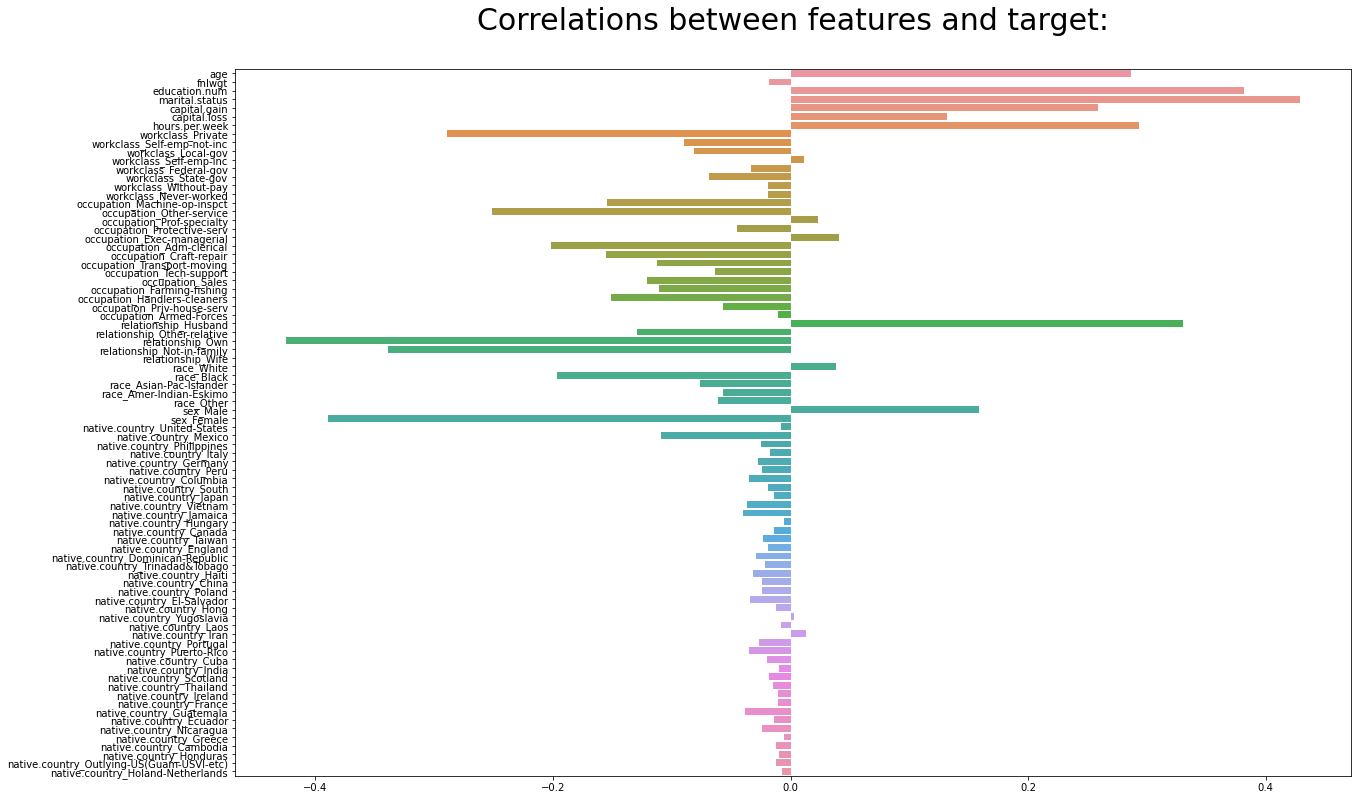

1. Feature Drop : id, education, Yeojohnson(capital.gain)
    accuracy : 0.8663  
3. Feature Drop : id, education,fnlwgt, Yeojohnson(capital.gain)
    accuracy : 0.8619
4. Feature Drop : id, education, Yeojohnson(all numerical var)
    accuracy : 0.8569
4. Feature Drop : id, education, Yeojohnson(loss , gain)
    accuracy : 0.8596
5. Feature Drop : id, education,Yeojohnson(capital.gain) , +feature(total_capital)
    accuracy : 0.8594
5. Feature Drop : id, education,Yeojohnson(capital.gain, total_capital) , +feature(total_capital)
    accuracy : 0.8640


In [68]:
from catboost import CatBoostClassifier

cbc = CatBoostClassifier(random_state=42)

cbc.fit(X_train,y_train)

pred=cbc.predict(X_test)

Learning rate set to 0.03601
0:	learn: 0.6600222	total: 69.4ms	remaining: 1m 9s
1:	learn: 0.6277762	total: 74.5ms	remaining: 37.2s
2:	learn: 0.6043408	total: 79.4ms	remaining: 26.4s
3:	learn: 0.5790007	total: 86.2ms	remaining: 21.5s
4:	learn: 0.5577734	total: 93.3ms	remaining: 18.6s
5:	learn: 0.5387434	total: 101ms	remaining: 16.7s
6:	learn: 0.5195777	total: 108ms	remaining: 15.3s
7:	learn: 0.5045994	total: 115ms	remaining: 14.3s
8:	learn: 0.4910019	total: 122ms	remaining: 13.4s
9:	learn: 0.4801516	total: 130ms	remaining: 12.9s
10:	learn: 0.4669281	total: 137ms	remaining: 12.3s
11:	learn: 0.4524474	total: 145ms	remaining: 11.9s
12:	learn: 0.4445883	total: 152ms	remaining: 11.6s
13:	learn: 0.4356377	total: 160ms	remaining: 11.2s
14:	learn: 0.4250348	total: 167ms	remaining: 11s
15:	learn: 0.4163191	total: 174ms	remaining: 10.7s
16:	learn: 0.4073879	total: 182ms	remaining: 10.5s
17:	learn: 0.3998833	total: 189ms	remaining: 10.3s
18:	learn: 0.3928581	total: 197ms	remaining: 10.1s
19:	learn

179:	learn: 0.2354104	total: 1.39s	remaining: 6.35s
180:	learn: 0.2351683	total: 1.4s	remaining: 6.34s
181:	learn: 0.2349207	total: 1.41s	remaining: 6.33s
182:	learn: 0.2346563	total: 1.41s	remaining: 6.32s
183:	learn: 0.2344481	total: 1.42s	remaining: 6.31s
184:	learn: 0.2342441	total: 1.43s	remaining: 6.3s
185:	learn: 0.2340221	total: 1.44s	remaining: 6.29s
186:	learn: 0.2338523	total: 1.44s	remaining: 6.28s
187:	learn: 0.2336687	total: 1.45s	remaining: 6.27s
188:	learn: 0.2333805	total: 1.46s	remaining: 6.26s
189:	learn: 0.2330582	total: 1.47s	remaining: 6.25s
190:	learn: 0.2328222	total: 1.47s	remaining: 6.25s
191:	learn: 0.2326244	total: 1.48s	remaining: 6.24s
192:	learn: 0.2323996	total: 1.49s	remaining: 6.23s
193:	learn: 0.2320796	total: 1.5s	remaining: 6.22s
194:	learn: 0.2318647	total: 1.5s	remaining: 6.21s
195:	learn: 0.2316922	total: 1.51s	remaining: 6.2s
196:	learn: 0.2314460	total: 1.52s	remaining: 6.19s
197:	learn: 0.2312958	total: 1.52s	remaining: 6.18s
198:	learn: 0.231

343:	learn: 0.2081116	total: 2.6s	remaining: 4.97s
344:	learn: 0.2079399	total: 2.61s	remaining: 4.96s
345:	learn: 0.2078224	total: 2.62s	remaining: 4.95s
346:	learn: 0.2076309	total: 2.63s	remaining: 4.94s
347:	learn: 0.2075105	total: 2.63s	remaining: 4.93s
348:	learn: 0.2074122	total: 2.64s	remaining: 4.92s
349:	learn: 0.2072913	total: 2.64s	remaining: 4.91s
350:	learn: 0.2071986	total: 2.65s	remaining: 4.9s
351:	learn: 0.2070975	total: 2.66s	remaining: 4.89s
352:	learn: 0.2070137	total: 2.66s	remaining: 4.88s
353:	learn: 0.2068538	total: 2.67s	remaining: 4.87s
354:	learn: 0.2067442	total: 2.67s	remaining: 4.86s
355:	learn: 0.2066140	total: 2.68s	remaining: 4.85s
356:	learn: 0.2065134	total: 2.69s	remaining: 4.84s
357:	learn: 0.2064106	total: 2.7s	remaining: 4.84s
358:	learn: 0.2062896	total: 2.71s	remaining: 4.83s
359:	learn: 0.2061829	total: 2.71s	remaining: 4.82s
360:	learn: 0.2060558	total: 2.72s	remaining: 4.81s
361:	learn: 0.2059599	total: 2.73s	remaining: 4.8s
362:	learn: 0.20

511:	learn: 0.1905713	total: 3.81s	remaining: 3.63s
512:	learn: 0.1905063	total: 3.82s	remaining: 3.63s
513:	learn: 0.1904457	total: 3.83s	remaining: 3.62s
514:	learn: 0.1903705	total: 3.83s	remaining: 3.61s
515:	learn: 0.1902960	total: 3.84s	remaining: 3.6s
516:	learn: 0.1901136	total: 3.85s	remaining: 3.6s
517:	learn: 0.1900431	total: 3.86s	remaining: 3.59s
518:	learn: 0.1899862	total: 3.86s	remaining: 3.58s
519:	learn: 0.1899422	total: 3.87s	remaining: 3.57s
520:	learn: 0.1898455	total: 3.88s	remaining: 3.57s
521:	learn: 0.1897796	total: 3.89s	remaining: 3.56s
522:	learn: 0.1896973	total: 3.89s	remaining: 3.55s
523:	learn: 0.1896377	total: 3.9s	remaining: 3.54s
524:	learn: 0.1895574	total: 3.91s	remaining: 3.54s
525:	learn: 0.1894901	total: 3.91s	remaining: 3.53s
526:	learn: 0.1894080	total: 3.92s	remaining: 3.52s
527:	learn: 0.1893270	total: 3.93s	remaining: 3.51s
528:	learn: 0.1892350	total: 3.94s	remaining: 3.5s
529:	learn: 0.1891161	total: 3.94s	remaining: 3.5s
530:	learn: 0.189

680:	learn: 0.1779506	total: 5.03s	remaining: 2.35s
681:	learn: 0.1779053	total: 5.04s	remaining: 2.35s
682:	learn: 0.1778467	total: 5.04s	remaining: 2.34s
683:	learn: 0.1777794	total: 5.05s	remaining: 2.33s
684:	learn: 0.1777300	total: 5.06s	remaining: 2.33s
685:	learn: 0.1776688	total: 5.06s	remaining: 2.32s
686:	learn: 0.1775671	total: 5.07s	remaining: 2.31s
687:	learn: 0.1775045	total: 5.08s	remaining: 2.3s
688:	learn: 0.1774258	total: 5.09s	remaining: 2.3s
689:	learn: 0.1774013	total: 5.09s	remaining: 2.29s
690:	learn: 0.1773224	total: 5.1s	remaining: 2.28s
691:	learn: 0.1772863	total: 5.11s	remaining: 2.27s
692:	learn: 0.1772283	total: 5.12s	remaining: 2.27s
693:	learn: 0.1771741	total: 5.12s	remaining: 2.26s
694:	learn: 0.1771175	total: 5.13s	remaining: 2.25s
695:	learn: 0.1770133	total: 5.14s	remaining: 2.24s
696:	learn: 0.1769732	total: 5.14s	remaining: 2.24s
697:	learn: 0.1769198	total: 5.15s	remaining: 2.23s
698:	learn: 0.1768605	total: 5.16s	remaining: 2.22s
699:	learn: 0.1

848:	learn: 0.1680497	total: 6.25s	remaining: 1.11s
849:	learn: 0.1679889	total: 6.25s	remaining: 1.1s
850:	learn: 0.1679483	total: 6.26s	remaining: 1.1s
851:	learn: 0.1678944	total: 6.27s	remaining: 1.09s
852:	learn: 0.1678336	total: 6.28s	remaining: 1.08s
853:	learn: 0.1678113	total: 6.28s	remaining: 1.07s
854:	learn: 0.1677630	total: 6.29s	remaining: 1.07s
855:	learn: 0.1677212	total: 6.3s	remaining: 1.06s
856:	learn: 0.1676306	total: 6.3s	remaining: 1.05s
857:	learn: 0.1676010	total: 6.31s	remaining: 1.04s
858:	learn: 0.1675368	total: 6.32s	remaining: 1.04s
859:	learn: 0.1674539	total: 6.33s	remaining: 1.03s
860:	learn: 0.1673920	total: 6.33s	remaining: 1.02s
861:	learn: 0.1673564	total: 6.34s	remaining: 1.01s
862:	learn: 0.1672947	total: 6.35s	remaining: 1.01s
863:	learn: 0.1672301	total: 6.36s	remaining: 1s
864:	learn: 0.1671720	total: 6.36s	remaining: 993ms
865:	learn: 0.1671333	total: 6.37s	remaining: 986ms
866:	learn: 0.1670532	total: 6.38s	remaining: 978ms
867:	learn: 0.16698

In [87]:
print(classification_report(y_test, pred))
accuracy_score(y_test, pred)

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      4003
           1       0.74      0.67      0.70      1241

    accuracy                           0.87      5244
   macro avg       0.82      0.80      0.81      5244
weighted avg       0.86      0.87      0.86      5244



0.8661327231121282

####

In [350]:
setup(data=train,target='target',fold_shuffle=True,session_id=123,fix_imbalance=True,transformation=True)

,Description,Value
0,session_id,123
1,Target,target
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(17480, 15)"
5,Missing Values,1
6,Numeric Features,6
7,Categorical Features,8
8,Ordinal Features,0
9,High Cardinality Features,0


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [351]:
models= compare_models(n_select=4, cross_validation=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8606,0.9208,0.7256,0.6969,0.7106,0.6189,0.6194,2.7910
catboost,CatBoost Classifier,0.8576,0.9208,0.7288,0.6872,0.7070,0.6131,0.6138,4.1070
lightgbm,Light Gradient Boosting Machine,0.8546,0.9199,0.7458,0.6737,0.7075,0.6111,0.6129,1.1290
rf,Random Forest Classifier,0.8417,0.8908,0.6663,0.6638,0.6648,0.5612,0.5614,0.4760
gbc,Gradient Boosting Classifier,0.8329,0.9131,0.7975,0.6123,0.6923,0.5803,0.5903,0.6090
ada,Ada Boost Classifier,0.8320,0.9089,0.7961,0.6107,0.6909,0.5783,0.5881,0.2350
et,Extra Trees Classifier,0.8307,0.8542,0.6396,0.6413,0.6402,0.5296,0.5298,0.5680
lr,Logistic Regression,0.8122,0.8999,0.8349,0.5697,0.6770,0.5513,0.5715,0.9330
dt,Decision Tree Classifier,0.8016,0.7474,0.6226,0.5729,0.5965,0.4654,0.4662,0.1610
svm,SVM - Linear Kernel,0.7970,0.0000,0.8356,0.5488,0.6607,0.5254,0.5506,0.1710


In [352]:
final_models= blend_models(models,choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8521,0.9118,0.6920,0.6849,0.6885,0.5915,0.5915
1,0.8595,0.9344,0.7474,0.6857,0.7152,0.6222,0.6232
2,0.8742,0.9224,0.7093,0.7455,0.7270,0.6453,0.6456
3,0.8570,0.9130,0.7153,0.6890,0.7019,0.6079,0.6081
4,0.8709,0.9233,0.7396,0.7196,0.7295,0.6447,0.6448
5,0.8651,0.9216,0.7326,0.7057,0.7189,0.6302,0.6304
6,0.8528,0.9140,0.7361,0.6709,0.7020,0.6045,0.6057
7,0.8684,0.9267,0.7431,0.7110,0.7267,0.6400,0.6403
8,0.8479,0.9117,0.7326,0.6594,0.6941,0.5933,0.5947
9,0.8667,0.9258,0.7396,0.7076,0.7233,0.6355,0.6358


In [353]:
pred=predict_model(final_models, data=test)

In [354]:
sample_submission['target'] = pred['Label']
sample_submission.to_csv("data/소득예측경진대회/submission.csv",index=False)